## Using Locally

In [103]:
# Question 1
import pandas as pd
import numpy as np
import json
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib
import pytz
import random
import dateutil.parser

# Question 3
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Question 8
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [104]:
file_direct = "ECE219_tweet_data_updated/"
f_cnt = 1
top_three_features = [(-1, -1, -1), (-1, -1, -1), (-1, -1, -1)]

## How to load json data

In [105]:
def loadFile(file_direct, hashtag):
    json_objects = list()
    filename = "updated_tweets_#" + str(hashtag) + ".txt"
    with open(file_direct + filename, "r") as file:
        line = file.readline()
        while line:
            json_objects.append(json.loads(line))
            line = file.readline()
    print(len(json_objects))
    return json_objects

json_gopatriots = loadFile(file_direct, "gopatriots")
json_gohawks = loadFile(file_direct, "gohawks")
json_nfl = loadFile(file_direct, "nfl")
json_patriots = loadFile(file_direct, "patriots")
json_sb49 = loadFile(file_direct, "sb49")
json_superbowl = loadFile(file_direct, "superbowl")

json_aggregate = json_gopatriots + json_gohawks + json_nfl + json_patriots + json_sb49 + json_superbowl
print(len(json_aggregate))

23511
169122
233022
440621
743649
1213813
2823738


In [106]:
def creationTimeParser(unix_time, time_zone = pytz.timezone('America/Los_Angeles')):
    date_object = datetime.datetime.fromtimestamp(unix_time, time_zone)
    date_object = date_object.replace(minute=0, second=0, microsecond=0)
    return date_object
  
def getStat(json_objects):
    hr2cnt = dict()
    # Description:
    # Get the the number of tweets, also features forom the tweet
    list_cnt = 0
    total_followers = 0
    total_tweets = 0
    time_zone = pytz.timezone('America/Los_Angeles')
    for i in range(len(json_objects)):
    # parse the avg tweet per hour
        parsed_time = creationTimeParser(json_objects[i]['citation_date'],  time_zone)
        if parsed_time in hr2cnt:
          hr2cnt[parsed_time] += 1
        else:
          hr2cnt[parsed_time] = 1
        total_followers += json_objects[i]['followers']
        total_tweets += json_objects[i]['total_citations']
    min_time = min(hr2cnt.keys())
    max_time = max(hr2cnt.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2cnt:
            hr2cnt[hour_time] = 0
        hour_time = hour_time + timedelta(hours=1)
    hr_np = np.fromiter(hr2cnt.values(), dtype=np.int).reshape((len(hr2cnt),1))
    min_time = min(hr2cnt.keys())
    max_time = max(hr2cnt.keys())
    diff_time = max_time - min_time + timedelta(hours=1)
    avg_tweets = hr_np.sum() / (diff_time.total_seconds()/3600)
    print( {'avg tweets per hour' : avg_tweets, 
          'avg followers per tweet' : total_followers / len(json_objects),
          'avg retweets per tweet' : total_tweets / len(json_objects)})
    return hr2cnt

In [107]:
# creationTimeParser(json_objects[0]['citation_date'])
# print(type(json_objects[0]))
stats_gopatriots = getStat(json_gopatriots)
stats_gohawks = getStat(json_gohawks)
stats_nfl = getStat(json_nfl)
stats_patriots = getStat(json_patriots)
stats_sb49 = getStat(json_sb49)
stats_superbowl = getStat(json_superbowl)

{'avg tweets per hour': 40.888695652173915, 'avg followers per tweet': 1427.2526051635405, 'avg retweets per tweet': 1.4081919101697078}
{'avg tweets per hour': 292.09326424870466, 'avg followers per tweet': 2217.9237355281984, 'avg retweets per tweet': 2.0132093991319877}
{'avg tweets per hour': 396.97103918228277, 'avg followers per tweet': 4662.37544523693, 'avg retweets per tweet': 1.5344602655543254}
{'avg tweets per hour': 750.6320272572402, 'avg followers per tweet': 3280.4635616550277, 'avg retweets per tweet': 1.7852871288476946}
{'avg tweets per hour': 1275.5557461406518, 'avg followers per tweet': 10374.160292019487, 'avg retweets per tweet': 2.52713444111402}
{'avg tweets per hour': 2067.824531516184, 'avg followers per tweet': 8814.96799424623, 'avg retweets per tweet': 2.3911895819207736}


## Question 2

In [108]:
def getTweetCount(json_objects):
    stat = getStat(json_objects)
    return stat
    
def getSortedKeys(hr2cnt):
    keylist = sorted(hr2cnt.keys())
    return keylist

# TODO: change the x ticks to display properly
def generatePlot(hr2cnt, filename):
    global f_cnt
    sorted_time = getSortedKeys(hr2cnt)
    sorted_vals = [hr2cnt[x] for x in sorted_time]
    plt.plot(sorted_time, sorted_vals)
    print("sorted_vals: ", len(sorted_vals))
    plt.xlabel('time')
    plt.ylabel('num of posts')
    plt.title("Question 2 Tag Name: " +filename)
    plt.figure(f_cnt)
    f_cnt = f_cnt + 1

def Question2(json_objects, tag_name):
    hr2cnt = getTweetCount(json_objects)
    keylist = getSortedKeys(hr2cnt)
    generatePlot(hr2cnt, tag_name)

{'avg tweets per hour': 2067.824531516184, 'avg followers per tweet': 8814.96799424623, 'avg retweets per tweet': 2.3911895819207736}
sorted_vals:  587


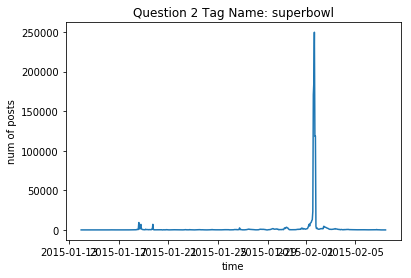

In [109]:
Question2(json_superbowl, "superbowl")

{'avg tweets per hour': 396.97103918228277, 'avg followers per tweet': 4662.37544523693, 'avg retweets per tweet': 1.5344602655543254}
sorted_vals:  587


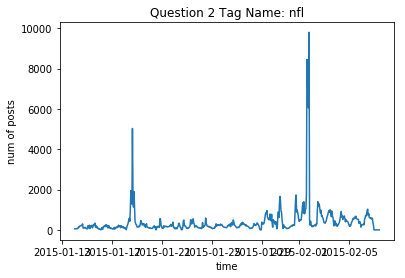

<Figure size 432x288 with 0 Axes>

In [110]:
Question2(json_nfl, "nfl")

## Question 3

In [113]:
def featureExtraction(json_objects):
    hr2feature = dict()
    for i in range(len(json_objects)):
        parsed_time = creationTimeParser(json_objects[i]['citation_date'])
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['followers']
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
        hour_time += timedelta(hours=1)
    return hr2feature

# convert a dictionary to numpy array
def convertDictToNumpy(parsed_features, feature_list):
    df = pd.DataFrame(parsed_features).T.sort_index()
    # create the label column
    df["next_num_tweets"] = df["num_tweets"].shift(-1)
    df = df[feature_list] # reorder the column based on feature
    df.drop(df.tail(1).index, inplace=True)
    train_set = df.values[:,:-1]
    labels = df.values[:,-1]
    labels = labels.reshape((len(labels), 1))
    return {"features" : train_set, "labels" : labels}

def drawScatterPlots(feature_value, predicted_Y, coef , message):
    global f_cnt
    #Fitted values against true values
    print ("Coefficeint: ", coef)
    fig, ax = plt.subplots()
    ax.plot([feature_value.min(),feature_value.max() ], [feature_value.min()*coef, feature_value.max()*coef],  'k--', lw=1)
    ax.scatter(x=feature_value, y = predicted_Y, marker=".",c="yellow", edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Feature values')
    ax.set_ylabel('Predicted values')
#     ax.set_xlim([0,feature_value.max()/4])
    plt.title(message)
    plt.figure(f_cnt)
    f_cnt = f_cnt + 1
    
def trainAndEvaluate(train_labels_pair, feature_list):
    global top_three_features
    # OLS Top three features and P values
    x_train = np.squeeze(train_labels_pair["features"])
    y_train = np.squeeze(train_labels_pair["labels"])
    ols = sm.OLS(y_train, x_train)
    res_vals = ols.fit()
    pred_vals = res_vals.predict(x_train)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_train, pred_vals))
    print("R square value: " + str(res_vals.rsquared))
    print("P values: ", res_vals.pvalues)
    idx_pvals_pair = list()
    for i in range(res_vals.pvalues.shape[0]):
        pair = (res_vals.pvalues[i], i)
        idx_pvals_pair.append(pair)
    idx_pvals_pair = sorted(idx_pvals_pair, key=lambda x: x[0])
    print("Top three features")
    for i in range(3):
        top_three_features[i] = (feature_list[idx_pvals_pair[i][1]], idx_pvals_pair[i][1], res_vals.params[idx_pvals_pair[i][1]])
        print("feature:", feature_list[idx_pvals_pair[i][1]], ", P value:", idx_pvals_pair[i][0])
        drawScatterPlots(x_train[:,idx_pvals_pair[i][1]],pred_vals,res_vals.params[idx_pvals_pair[i][1]], "feature: "+ str(feature_list[idx_pvals_pair[i][1]]))
    print ("summary: ", res_vals.summary())
    return

def trainAndPlot(json_object, feature_list):
    parsed_features = featureExtraction(json_object)
    train_labels_pair = convertDictToNumpy(parsed_features, feature_list)
    trainAndEvaluate(train_labels_pair, feature_list)
    
    

Mean squared error: 27610.11
R square value: 0.6372256940098271
P values:  [0.47142064 0.95397142 0.5796288  0.00941955 0.27931161]
Top three features
feature: num_retweets , P value: 0.009419548144867134
Coefficeint:  0.497248361135163
feature: num_tweets , P value: 0.27931161073495586
Coefficeint:  0.30807556505456013
feature: hr_of_day , P value: 0.4714206412129198
Coefficeint:  0.3894646683029611
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     199.9
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          9.65e-123
Time:                        16:19:15   Log-Likelihood:                -3749.3
No. Observations:                 574   AIC:                             7509.
Df Residuals:                    

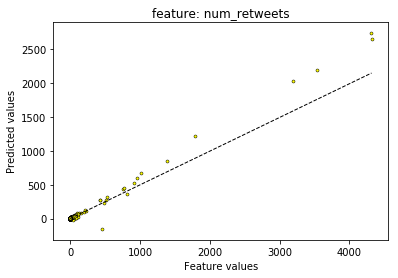

<Figure size 432x288 with 0 Axes>

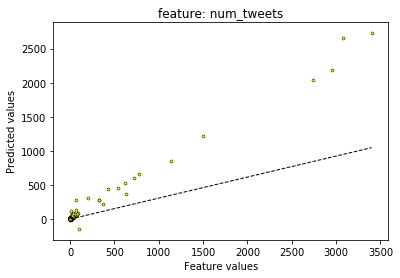

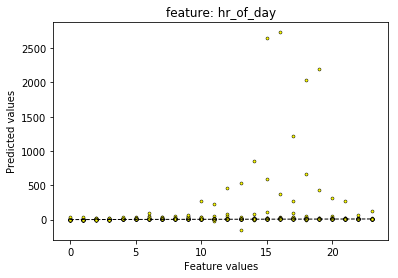

In [114]:
# Running Question 3
feature_list = ['hr_of_day', 'max_followers', 'num_followers', 'num_retweets', 'num_tweets', 'next_num_tweets']
# json_file_list = [json_gopatriots, json_gohawks, json_nfl, json_patriots, json_sb49, json_superbowl]
trainAndPlot(json_gopatriots,feature_list)

Mean squared error: 760963.89
R square value: 0.5041002071921129
P values:  [1.04619105e-02 6.31486219e-01 1.52369053e-02 1.60947513e-03
 2.15583400e-14]
Top three features
feature: num_tweets , P value: 2.1558340030499784e-14
Coefficeint:  1.2856038749002514
feature: num_retweets , P value: 0.0016094751255168772
Coefficeint:  -0.13784997920291553
feature: hr_of_day , P value: 0.010461910536450686
Coefficeint:  7.591914079487766
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     116.5
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           7.10e-85
Time:                        16:19:25   Log-Likelihood:                -4733.9
No. Observations:                 578   AIC:                             9478.
Df R

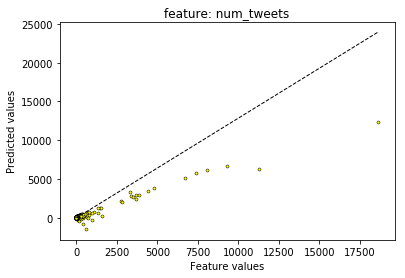

<Figure size 432x288 with 0 Axes>

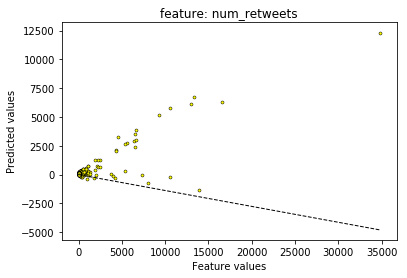

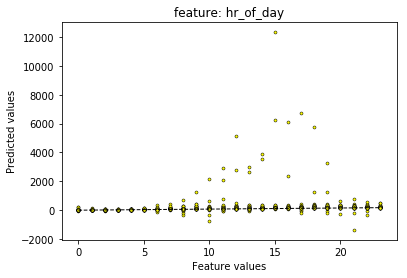

In [115]:
trainAndPlot(json_gohawks,feature_list)

Mean squared error: 273848.28
R square value: 0.6521006506177033
P values:  [1.30036264e-04 2.48610844e-03 2.42865533e-05 4.79416843e-03
 2.99044196e-06]
Top three features
feature: num_tweets , P value: 2.9904419649562853e-06
Coefficeint:  0.6317477955361015
feature: num_followers , P value: 2.4286553288980798e-05
Coefficeint:  0.00010632416839108674
feature: hr_of_day , P value: 0.0001300362640563617
Coefficeint:  7.567913928817468
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     217.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.23e-130
Time:                        16:19:31   Log-Likelihood:                -4500.0
No. Observations:                 586   AIC:                             9010.

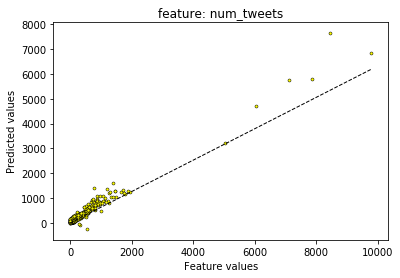

<Figure size 432x288 with 0 Axes>

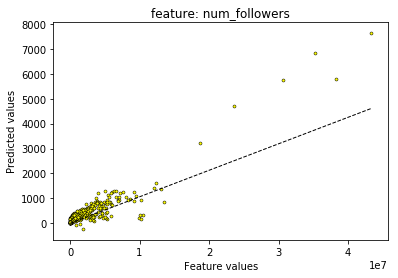

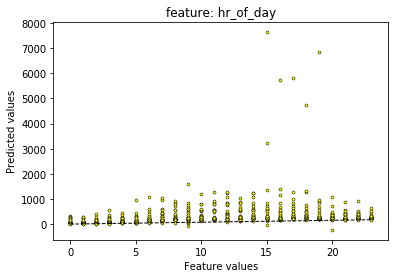

In [116]:
trainAndPlot(json_nfl,feature_list)

Mean squared error: 5189462.12
R square value: 0.6794725841702596
P values:  [5.05783085e-01 1.37065456e-01 6.60651423e-01 2.42607082e-01
 7.59459794e-34]
Top three features
feature: num_tweets , P value: 7.594597943338497e-34
Coefficeint:  0.9147786766262829
feature: max_followers , P value: 0.13706545617711524
Coefficeint:  0.00013516373596227354
feature: num_retweets , P value: 0.24260708193738115
Coefficeint:  -0.06754640936159372
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     246.3
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          5.98e-141
Time:                        16:19:51   Log-Likelihood:                -5361.9
No. Observations:                 586   AIC:                         1.073e+0

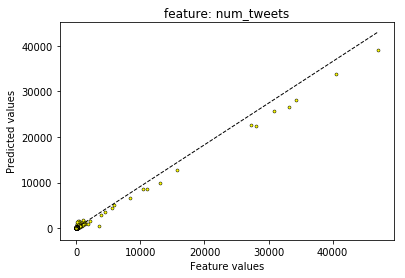

<Figure size 432x288 with 0 Axes>

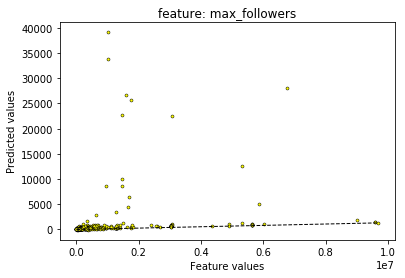

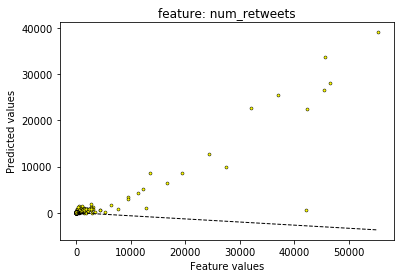

In [117]:
trainAndPlot(json_patriots,feature_list)

Mean squared error: 16199530.45
R square value: 0.8082352136527163
P values:  [8.12754589e-01 2.27035922e-02 4.29712429e-01 4.00144711e-02
 2.95505976e-34]
Top three features
feature: num_tweets , P value: 2.955059757254579e-34
Coefficeint:  1.1374142832795866
feature: max_followers , P value: 0.022703592159847095
Coefficeint:  9.853880105915424e-05
feature: num_retweets , P value: 0.04001447108158907
Coefficeint:  -0.16184634484212101
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     486.4
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          3.24e-204
Time:                        16:20:38   Log-Likelihood:                -5656.6
No. Observations:                 582   AIC:                         1.132e+

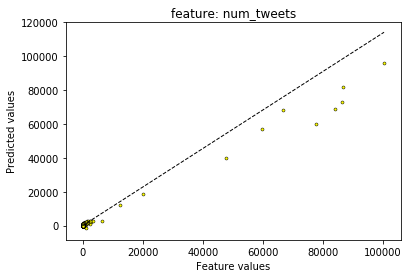

<Figure size 432x288 with 0 Axes>

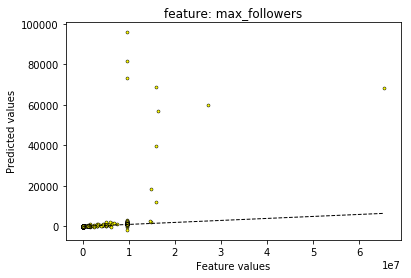

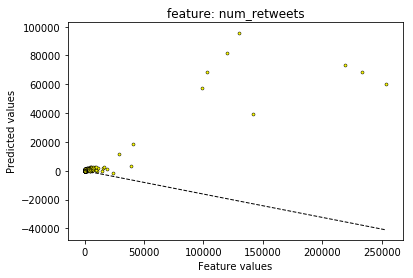

In [120]:
trainAndPlot(json_sb49,feature_list)

Mean squared error: 52488994.91
R square value: 0.803041998925358
P values:  [2.77906836e-001 7.12296562e-007 6.71733985e-010 3.40873070e-008
 9.67194039e-113]
Top three features
feature: num_tweets , P value: 9.671940388378623e-113
Coefficeint:  2.276527380211978
feature: num_followers , P value: 6.717339848290527e-10
Coefficeint:  -0.0001374204044257611
feature: num_retweets , P value: 3.408730696891899e-08
Coefficeint:  -0.2553165131801004
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     473.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          2.80e-202
Time:                        16:20:20   Log-Likelihood:                -6039.9
No. Observations:                 586   AIC:                         

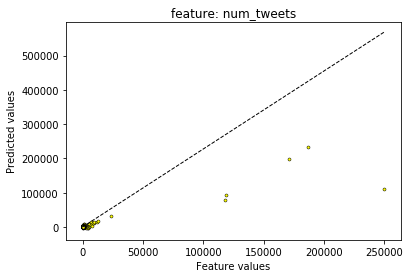

<Figure size 432x288 with 0 Axes>

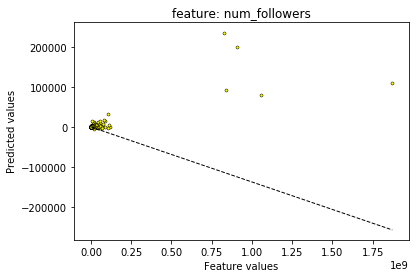

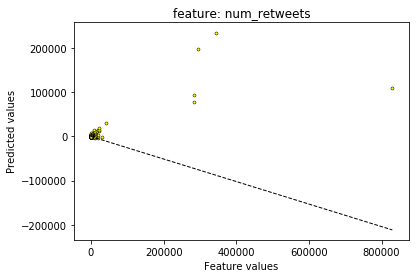

In [119]:
trainAndPlot(json_superbowl,feature_list)

## Question 4 & 5

### Selected Features
count of happy emojis
count of sad emojis
url count
user mentioned count


In [121]:
def featureExtractionCustomized(json_objects):
    hr2feature = dict()
    happy_emoji = [":)", ":-)", ":')", ":]", "=]", ":)"]
    sad_emoji = [":-(", ":'(", ":[", "=["]
    
    for i in range(len(json_objects)):
        parsed_time = creationTimeParser(json_objects[i]['citation_date'])
        tweet_text = json_objects[i]['text']
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
            hr2feature[parsed_time]["user_mentioned_cnt"] += json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] += json_objects[i]['url_cnt']
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["happy_emoji_cnt"] = 0
            hr2feature[parsed_time]["sad_emoji_cnt"] = 0
            hr2feature[parsed_time]["user_mentioned_cnt"] = json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] = json_objects[i]['url_cnt']
        
        if hasEmoticon(happy_emoji, tweet_text):
            hr2feature[parsed_time]["happy_emoji_cnt"] += 1
        if hasEmoticon(sad_emoji, tweet_text):
            hr2feature[parsed_time]["sad_emoji_cnt"] += 1
            
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
            hr2feature[hour_time]["sad_emoji_cnt"] = 0
            hr2feature[hour_time]["happy_emoji_cnt"] = 0
            hr2feature[hour_time]["user_mentioned_cnt"] = 0
            hr2feature[hour_time]["url_cnt"] = 0
            
        hour_time += timedelta(hours=1)
    return hr2feature

def hasEmoticon(emoji_list, tweet_text):
    for emoji in emoji_list:
        if emoji in tweet_text:
            return True
    return False

def trainAndPlotCustomized(json_object, feature_list_updated):
    parsed_features = featureExtractionCustomized(json_object)
    train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
    trainAndEvaluate(train_labels_pair, feature_list_updated)
    

Mean squared error: 9325.34
R square value: 0.8774726165522032
P values:  [7.01529382e-02 6.78204240e-07 1.53634462e-05 8.96991875e-06
 7.28216169e-81 3.45205616e-01 1.28988208e-73 1.43881749e-07
 1.06749096e-01]
Top three features
feature: happy_emoji_cnt , P value: 7.282161691952267e-81
Coefficeint:  -174.48921096168107
feature: user_mentioned_cnt , P value: 1.2898820815369715e-73
Coefficeint:  8.044450240419753
feature: url_cnt , P value: 1.4388174876533967e-07
Coefficeint:  3.053911771619279
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     449.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          5.66e-251
Time:                        16:21:04   Log-Likelihood:                -3437.8
No. Observation

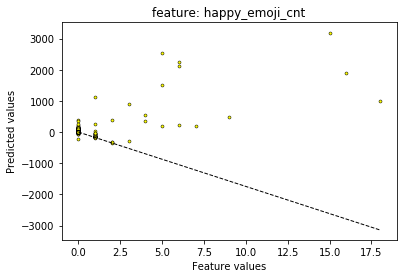

<Figure size 432x288 with 0 Axes>

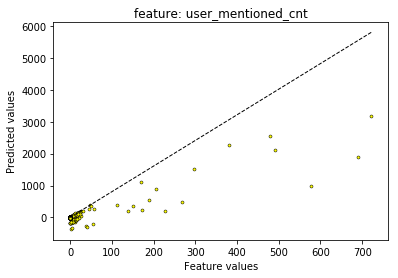

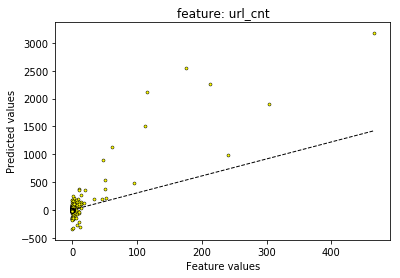

In [122]:
# Running Question 4
feature_list_updated = ['hr_of_day', 'max_followers', 
                        'num_followers', 'num_retweets', 
                        'happy_emoji_cnt', 'sad_emoji_cnt', 
                        'user_mentioned_cnt', 'url_cnt',
                        'num_tweets' ,'next_num_tweets']

trainAndPlotCustomized(json_gopatriots,feature_list_updated)

Mean squared error: 577818.60
R square value: 0.6234510907475204
P values:  [3.29245076e-01 5.69531034e-01 4.00808352e-02 6.83885610e-01
 1.22148788e-01 1.68160854e-12 2.82577279e-01 5.36889347e-17
 3.47239965e-03]
Top three features
feature: url_cnt , P value: 5.368893471679995e-17
Coefficeint:  7.89154347035918
feature: sad_emoji_cnt , P value: 1.681608538561575e-12
Coefficeint:  864.3932753249821
feature: num_tweets , P value: 0.003472399650845431
Coefficeint:  0.644059944884301
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     104.7
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.39e-114
Time:                        16:21:08   Log-Likelihood:                -4654.3
No. Observations:            

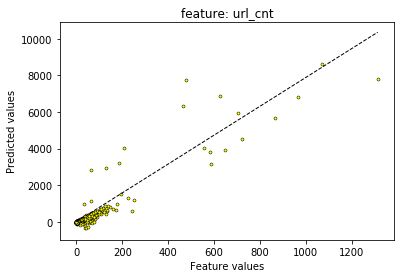

<Figure size 432x288 with 0 Axes>

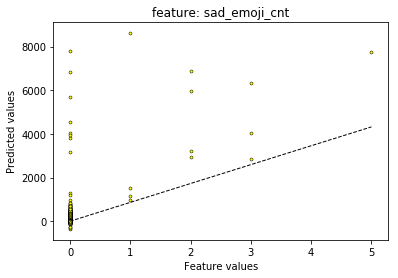

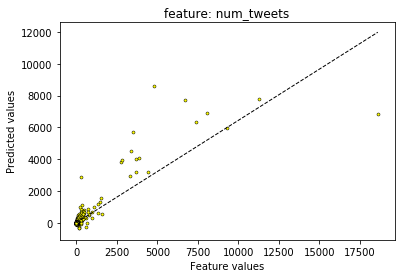

In [123]:
trainAndPlotCustomized(json_gohawks,feature_list_updated)

Mean squared error: 225143.78
R square value: 0.713975290995982
P values:  [7.37591942e-01 3.71828255e-02 2.06030086e-02 6.72989864e-01
 5.22271789e-15 2.16865080e-02 1.04115537e-04 3.63237350e-11
 9.81328211e-02]
Top three features
feature: happy_emoji_cnt , P value: 5.222717892875908e-15
Coefficeint:  114.87343391680255
feature: url_cnt , P value: 3.632373495197207e-11
Coefficeint:  0.8674348079709744
feature: user_mentioned_cnt , P value: 0.00010411553715715543
Coefficeint:  2.6513348900536418
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     160.0
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.66e-150
Time:                        16:21:14   Log-Likelihood:                -4442.6
No. Observatio

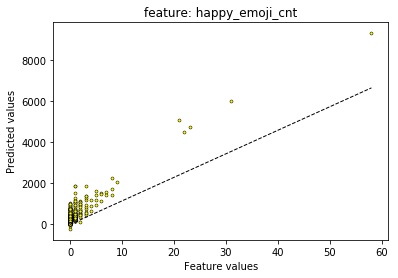

<Figure size 432x288 with 0 Axes>

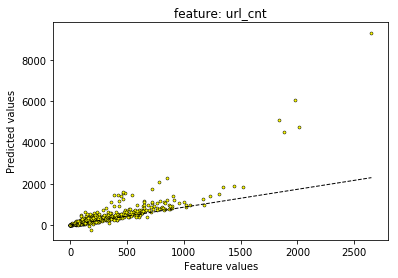

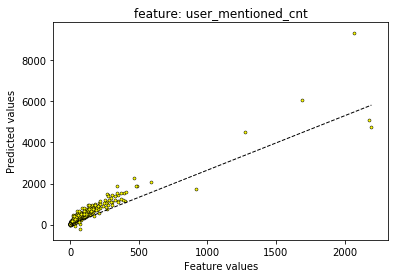

In [124]:
trainAndPlotCustomized(json_nfl,feature_list_updated)

Mean squared error: 3694750.02
R square value: 0.7717935595663474
P values:  [1.98390461e-01 1.46482278e-07 1.55002302e-18 1.11893084e-01
 3.92399082e-06 3.66906494e-03 6.73446215e-02 2.28000829e-01
 3.35681622e-01]
Top three features
feature: num_followers , P value: 1.5500230198667302e-18
Coefficeint:  0.0004314849349168283
feature: max_followers , P value: 1.4648227793658114e-07
Coefficeint:  -0.0005223201276815939
feature: happy_emoji_cnt , P value: 3.923990817275451e-06
Coefficeint:  -191.0144245602798
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     216.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          1.10e-178
Time:                        16:21:23   Log-Likelihood:                -5262.4
No.

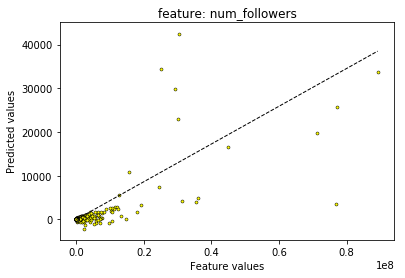

<Figure size 432x288 with 0 Axes>

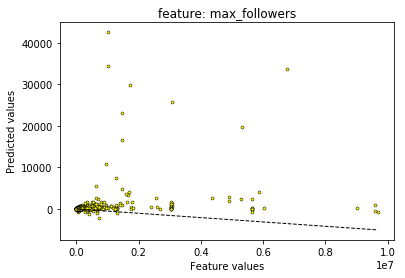

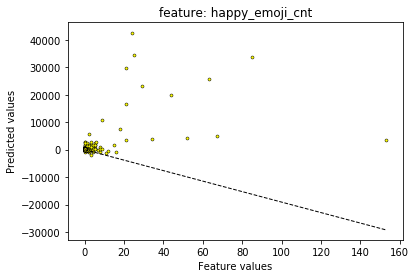

In [125]:
trainAndPlotCustomized(json_patriots,feature_list_updated)

Mean squared error: 12311366.55
R square value: 0.8542620365657431
P values:  [2.37200940e-01 7.12492058e-03 3.86919147e-02 5.16399876e-02
 2.32953374e-16 1.20786429e-03 3.02801173e-02 5.68224321e-01
 7.90197085e-06]
Top three features
feature: happy_emoji_cnt , P value: 2.329533744726656e-16
Coefficeint:  660.9137769895706
feature: num_tweets , P value: 7.901970851073756e-06
Coefficeint:  -1.8340359143769183
feature: sad_emoji_cnt , P value: 0.001207864288965355
Coefficeint:  -1857.2756778908556
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     373.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          4.69e-233
Time:                        16:21:38   Log-Likelihood:                -5576.7
No. Observatio

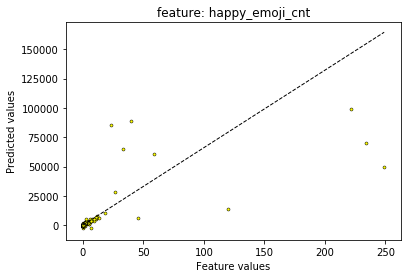

<Figure size 432x288 with 0 Axes>

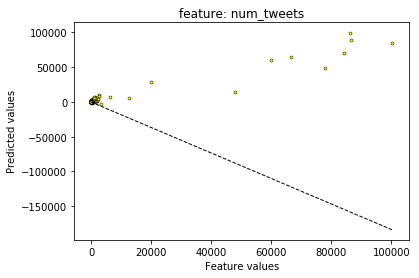

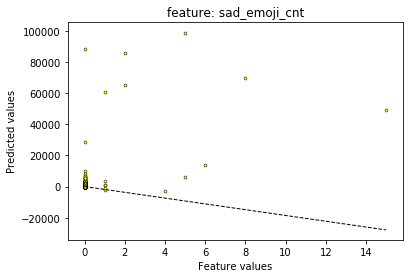

In [126]:
trainAndPlotCustomized(json_sb49,feature_list_updated)

Mean squared error: 32528318.01
R square value: 0.8779417951598005
P values:  [1.93197044e-02 7.09778878e-01 1.26284992e-03 9.69024473e-30
 8.40087510e-04 9.13382950e-07 5.67992456e-45 6.17142765e-01
 1.34264138e-01]
Top three features
feature: user_mentioned_cnt , P value: 5.679924559447648e-45
Coefficeint:  13.018558552627667
feature: num_retweets , P value: 9.690244729065033e-30
Coefficeint:  -0.8415575922162639
feature: sad_emoji_cnt , P value: 9.133829498642921e-07
Coefficeint:  -935.4871233612907
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     461.1
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          6.82e-257
Time:                        16:21:56   Log-Likelihood:                -5899.7
No. Obse

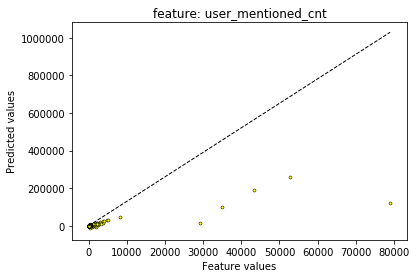

<Figure size 432x288 with 0 Axes>

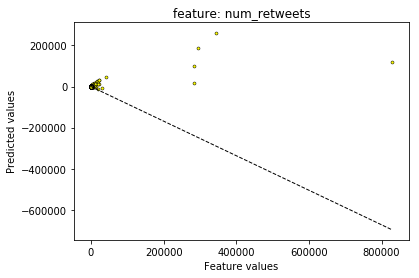

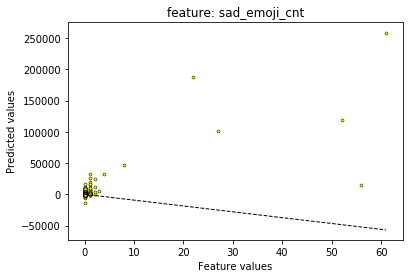

In [127]:
trainAndPlotCustomized(json_superbowl,feature_list_updated)

Mean squared error: 118337780.26
R square value: 0.855532120277054
P values:  [8.05406695e-02 9.55497926e-01 4.13178761e-10 6.66880824e-24
 1.96661088e-02 3.17130113e-01 1.46432028e-07 1.88420308e-06
 1.07671049e-01]
Top three features
feature: num_retweets , P value: 6.668808240684131e-24
Coefficeint:  -0.6514408681812804
feature: num_followers , P value: 4.131787613815151e-10
Coefficeint:  0.00014981137648645632
feature: user_mentioned_cnt , P value: 1.464320280148464e-07
Coefficeint:  2.459417542833044
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     379.7
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          8.21e-236
Time:                        16:22:36   Log-Likelihood:                -6278.1
No. O

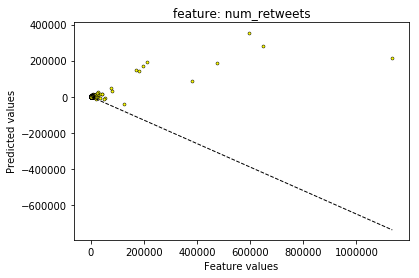

<Figure size 432x288 with 0 Axes>

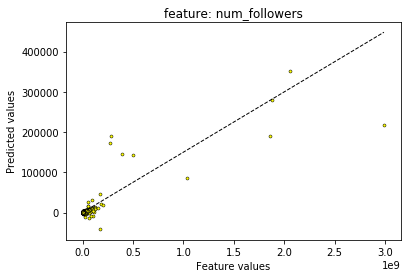

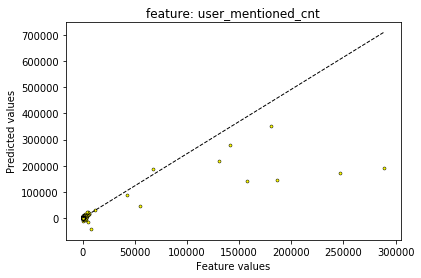

In [128]:
trainAndPlotCustomized(json_aggregate,feature_list_updated)

## Question 6 & 7

In [129]:
def createTime(year, month, date, hour, minute=0, second=0):
    datetime_end = datetime.datetime(year, month, date, hour, minute,second)
    time_zone = pytz.timezone("America/Los_Angeles")
    datetime_end = time_zone.localize(datetime_end)
    print(datetime_end)
    print("year", datetime_end.year, 
          " month", datetime_end.month,
          " day", datetime_end.day,
          " hour", datetime_end.hour,
          " minute", datetime_end.minute,
          " second", datetime_end.second)
    return datetime_end


In [130]:
datatime_start = createTime(year=2015, month=2, date=1, hour=8)
datatime_end = createTime(year=2015, month=2, date=1, hour=20)

def creationTimeParserFiveMinutes(unix_time, time_zone = pytz.timezone('America/Los_Angeles')):
    date_object = datetime.datetime.fromtimestamp(unix_time, time_zone)
    date_object = date_object - datetime.timedelta(minutes=date_object.minute%5, 
                                                  seconds = date_object.second,
                                                  microseconds = date_object.microsecond)
    return date_object
  

def featureExtractionCustomizedFiveMinutes(json_objects):
    hr2feature = dict()
    happy_emoji = [":)", ":-)", ":')", ":]", "=]", ":)"]
    sad_emoji = [":-(", ":'(", ":[", "=["]
    
    for i in range(len(json_objects)):
        parsed_time = creationTimeParserFiveMinutes(json_objects[i]['citation_date'])
        tweet_text = json_objects[i]['text']
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
            hr2feature[parsed_time]["user_mentioned_cnt"] += json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] += json_objects[i]['url_cnt']
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["happy_emoji_cnt"] = 0
            hr2feature[parsed_time]["sad_emoji_cnt"] = 0
            hr2feature[parsed_time]["user_mentioned_cnt"] = json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] = json_objects[i]['url_cnt']
        
        if hasEmoticon(happy_emoji, tweet_text):
            hr2feature[parsed_time]["happy_emoji_cnt"] += 1
        if hasEmoticon(sad_emoji, tweet_text):
            hr2feature[parsed_time]["sad_emoji_cnt"] += 1
            
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    minute_time = min_time + timedelta(minutes=5)
    while minute_time < max_time:
        if minute_time not in hr2feature:
            hr2feature[minute_time] = dict()
            hr2feature[minute_time]["hr_of_day"] = minute_time.hour
            hr2feature[minute_time]["num_tweets"] = 0
            hr2feature[minute_time]["num_retweets"] = 0
            hr2feature[minute_time]["num_followers"] = 0
            hr2feature[minute_time]["max_followers"] = 0
            hr2feature[minute_time]["sad_emoji_cnt"] = 0
            hr2feature[minute_time]["happy_emoji_cnt"] = 0
            hr2feature[minute_time]["user_mentioned_cnt"] = 0
            hr2feature[minute_time]["url_cnt"] = 0
            
        minute_time += timedelta(minutes=5)
    return hr2feature


def hasEmoticon(emoji_list, tweet_text):
    for emoji in emoji_list:
        if emoji in tweet_text:
            return True
    return False


def splitTweetByTimePeriod(json_objects):
    first_period_json = list()
    second_period_json = list()
    third_period_json = list()
    for i in range(len(json_objects)):
        parsed_time = datetime.datetime.fromtimestamp(json_objects[i]['citation_date'], pytz.timezone('America/Los_Angeles'))
        if parsed_time < datatime_start:
            first_period_json.append(json_objects[i])
        elif parsed_time > datatime_end:
            third_period_json.append(json_objects[i])
        else:
            second_period_json.append(json_objects[i])
            
    print(len(first_period_json), len(second_period_json), len(third_period_json))
    return first_period_json, second_period_json, third_period_json

2015-02-01 08:00:00-08:00
year 2015  month 2  day 1  hour 8  minute 0  second 0
2015-02-01 20:00:00-08:00
year 2015  month 2  day 1  hour 20  minute 0  second 0


### go_patriots

5961 16739 811
Mean squared error: 1421.95
R square value: 0.6682109804307836
P values:  [2.54966736e-03 1.63628533e-07 2.29260308e-07 6.96352826e-04
 2.23220087e-05 3.23309345e-01 1.62131766e-17 8.33451432e-01
 1.31920334e-09]
Top three features
feature: user_mentioned_cnt , P value: 1.6213176586156522e-17
Coefficeint:  3.524837023812456
feature: num_tweets , P value: 1.3192033396047598e-09
Coefficeint:  1.1815329376078034
feature: max_followers , P value: 1.636285330353959e-07
Coefficeint:  0.0009266377856519656
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     96.00
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.32e-97
Time:                        16:22:51   Log-Likelihood:                -221

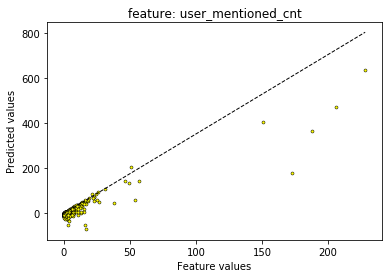

<Figure size 432x288 with 0 Axes>

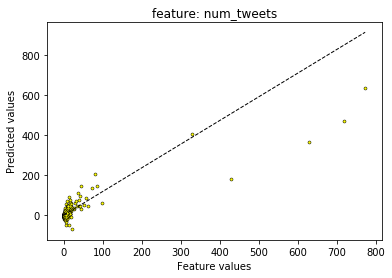

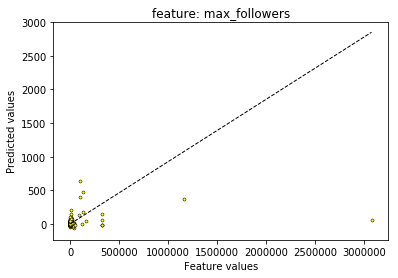

In [131]:
json_file_list = [json_gopatriots, json_gohawks, json_nfl, json_patriots, json_sb49, json_superbowl, json_aggregate]
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_gopatriots)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 13591.79
R square value: 0.6548494345928143
P values:  [7.08340220e-04 6.42900740e-01 4.98855677e-01 1.32418146e-02
 5.57074861e-01 5.51928644e-01 3.33502590e-02 1.35692342e-01
 9.93656065e-01]
Top three features
feature: hr_of_day , P value: 0.0007083402199518213
Coefficeint:  4.98292417929162
feature: num_retweets , P value: 0.013241814561352209
Coefficeint:  0.7089657589685838
feature: user_mentioned_cnt , P value: 0.033350258950589066
Coefficeint:  -2.2337387805544506
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     32.02
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.05e-27
Time:                        16:23:35   Log-Likelihood:                -883.39
No. Observations:  

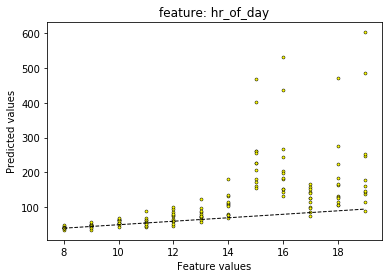

<Figure size 432x288 with 0 Axes>

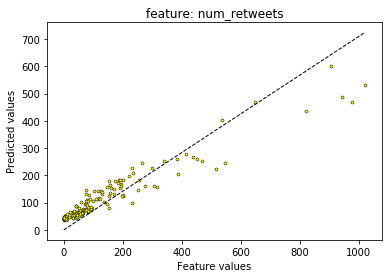

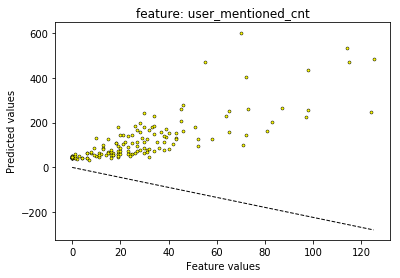

In [132]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 17.13
R square value: 0.9149492868667216
P values:  [9.56741823e-01 1.85111930e-04 5.51374278e-07 1.17337996e-02
 5.96212834e-17 3.20915063e-16 6.47537115e-25 1.83598996e-04
 1.27429091e-19]
Top three features
feature: user_mentioned_cnt , P value: 6.475371150976865e-25
Coefficeint:  -3.042715867502446
feature: num_tweets , P value: 1.274290913426529e-19
Coefficeint:  1.8737217436935174
feature: happy_emoji_cnt , P value: 5.96212833562138e-17
Coefficeint:  30.519910244111326
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     154.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           7.73e-58
Time:                        16:23:41   Log-Likelihood:                -349.23
No. Observations

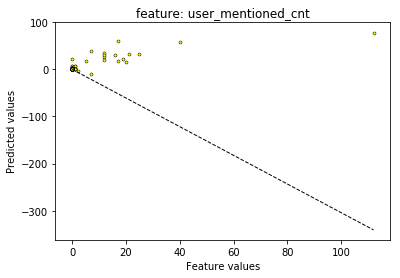

<Figure size 432x288 with 0 Axes>

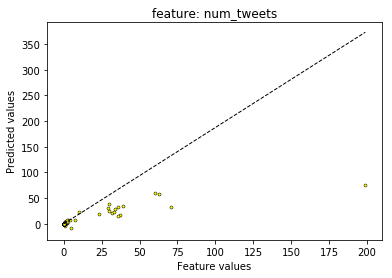

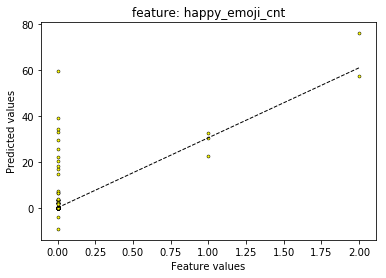

In [133]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

### go_hawks

106527 57158 5437
Mean squared error: 632589.52
R square value: 0.4195209040988722
P values:  [8.39941501e-01 4.14109093e-01 5.40646966e-02 2.80434347e-02
 8.24788800e-02 2.64648416e-10 6.97262520e-04 3.85042709e-01
 2.04826459e-02]
Top three features
feature: sad_emoji_cnt , P value: 2.6464841590478394e-10
Coefficeint:  908.1869829823854
feature: user_mentioned_cnt , P value: 0.0006972625204287503
Coefficeint:  2.7910539509347787
feature: num_tweets , P value: 0.020482645947644613
Coefficeint:  0.7469270526913452
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     34.53
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.04e-45
Time:                        16:23:49   Log-Likelihood:                -355

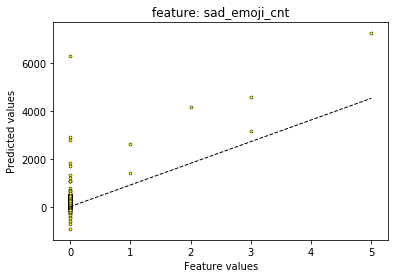

<Figure size 432x288 with 0 Axes>

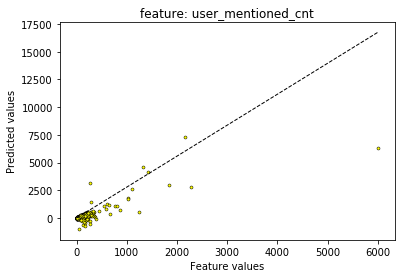

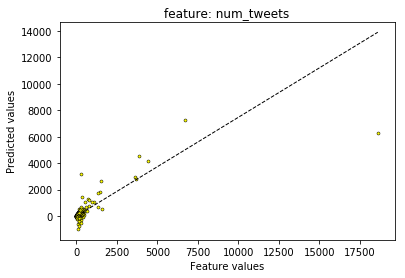

In [134]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_gohawks)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 68985.41
R square value: 0.7711735772408022
P values:  [4.45363139e-03 1.76950978e-01 9.18635989e-02 6.81468517e-01
 7.69613544e-01 8.67441314e-01 6.84535638e-02 1.46938964e-02
 2.38011164e-04]
Top three features
feature: num_tweets , P value: 0.00023801116417299505
Coefficeint:  0.8770226757215681
feature: hr_of_day , P value: 0.004453631390720618
Coefficeint:  10.909298742337441
feature: url_cnt , P value: 0.014693896405358684
Coefficeint:  3.237178277227294
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     50.18
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.19e-38
Time:                        16:23:55   Log-Likelihood:                -999.54
No. Observations:              

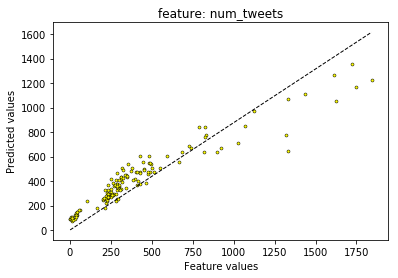

<Figure size 432x288 with 0 Axes>

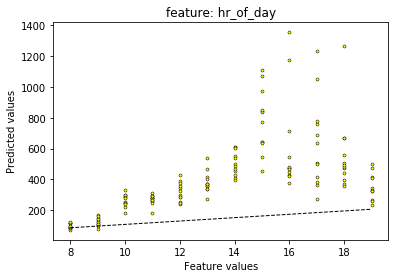

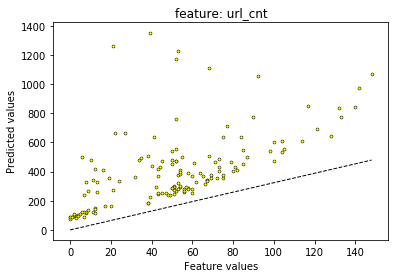

In [135]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 1415.48
R square value: 0.885136180229501
P values:  [8.40585238e-01 1.83076400e-03 1.34241059e-01 6.91941585e-02
 1.34902811e-06 2.90219650e-01 4.71642247e-01 8.29061192e-02
 2.85237715e-01]
Top three features
feature: happy_emoji_cnt , P value: 1.3490281102807391e-06
Coefficeint:  66.41341754670285
feature: max_followers , P value: 0.0018307640046222125
Coefficeint:  -0.0005986056707152415
feature: num_retweets , P value: 0.0691941584663511
Coefficeint:  0.025557563036071866
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     100.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.04e-50
Time:                        16:24:02   Log-Likelihood:                -635.87
No. Observatio

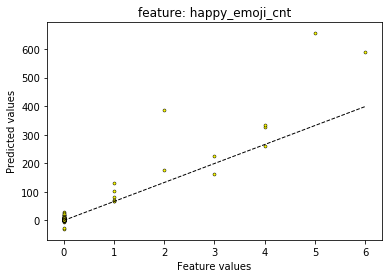

<Figure size 432x288 with 0 Axes>

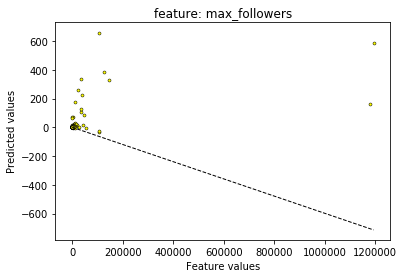

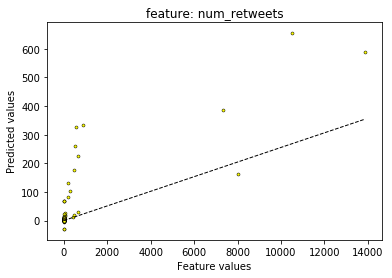

In [136]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

### nfl

120957 46958 65107
Mean squared error: 60824.06
R square value: 0.7115216117056096
P values:  [7.09151729e-02 6.66618439e-01 4.06592605e-01 5.52556020e-01
 1.14724137e-07 7.60079414e-01 3.44756902e-02 2.02979397e-05
 9.81518268e-01]
Top three features
feature: happy_emoji_cnt , P value: 1.1472413684289516e-07
Coefficeint:  95.71855639479696
feature: url_cnt , P value: 2.0297939702366175e-05
Coefficeint:  0.45973328950311226
feature: user_mentioned_cnt , P value: 0.03447569016583148
Coefficeint:  1.1431332362575435
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     117.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          3.34e-110
Time:                        16:24:13   Log-Likelihood:                -304

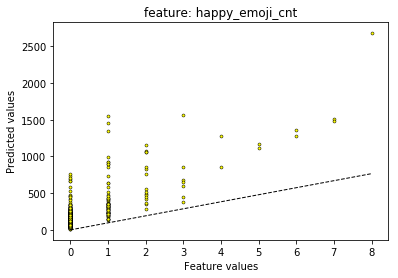

<Figure size 432x288 with 0 Axes>

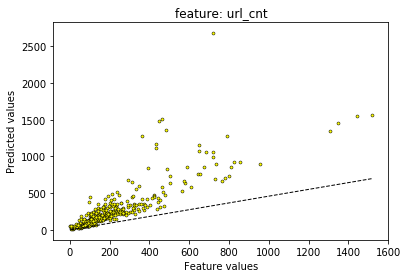

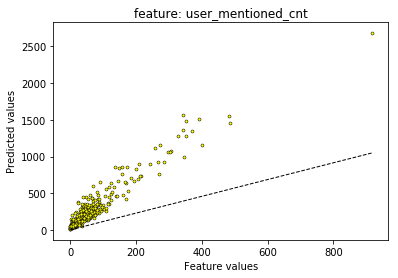

In [137]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_nfl)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 19755.93
R square value: 0.9113072989737111
P values:  [4.19999230e-03 7.17792494e-01 1.46695618e-01 1.44116936e-01
 6.02341449e-01 1.12142451e-02 7.79475035e-02 8.83563396e-01
 6.74462897e-18]
Top three features
feature: num_tweets , P value: 6.744628969020961e-18
Coefficeint:  1.3501298843634064
feature: hr_of_day , P value: 0.0041999922974108065
Coefficeint:  5.782998698593475
feature: sad_emoji_cnt , P value: 0.01121424509276023
Coefficeint:  -110.57393507516574
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     153.0
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.56e-66
Time:                        16:24:20   Log-Likelihood:                -910.13
No. Observations:        

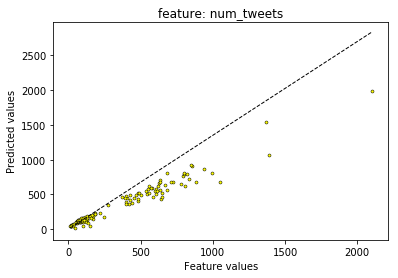

<Figure size 432x288 with 0 Axes>

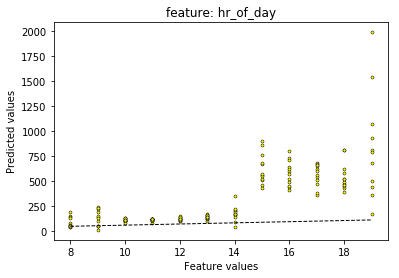

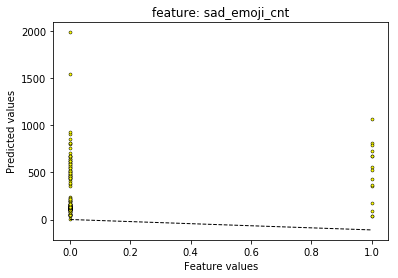

In [138]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 16884.89
R square value: 0.9469024153469358
P values:  [0.34822884 0.91496429 0.90644514 0.27589568 0.01722039 0.33199689
 0.42488628 0.52897557 0.02891159]
Top three features
feature: happy_emoji_cnt , P value: 0.017220391729664577
Coefficeint:  42.32251611619642
feature: num_tweets , P value: 0.028911585064500592
Coefficeint:  0.8110184875574431
feature: num_retweets , P value: 0.2758956825374237
Coefficeint:  -0.05739675683779949
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     247.7
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           3.23e-75
Time:                        16:24:23   Log-Likelihood:                -842.33
No. Observations:                 134   AIC:               

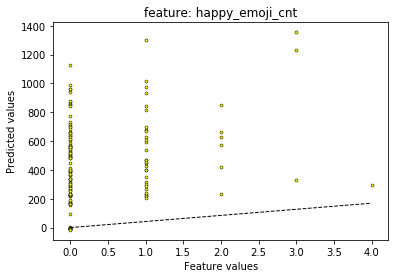

<Figure size 432x288 with 0 Axes>

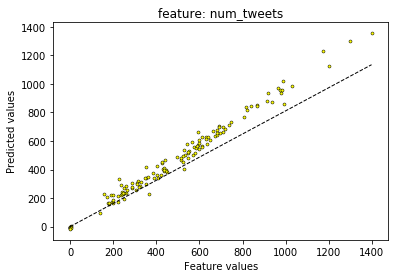

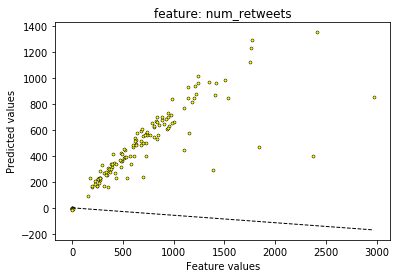

In [139]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

### patriots

135525 279370 25726
Mean squared error: 314508.19
R square value: 0.6412036336981739
P values:  [3.13037028e-03 3.73485383e-12 8.43251227e-16 7.23965213e-01
 3.19067021e-06 1.88071495e-01 9.72183636e-01 1.98101285e-02
 1.02392471e-01]
Top three features
feature: num_followers , P value: 8.432512272849495e-16
Coefficeint:  0.00026425068424862906
feature: max_followers , P value: 3.734853831315023e-12
Coefficeint:  -0.00034579506363314056
feature: happy_emoji_cnt , P value: 3.1906702096893023e-06
Coefficeint:  -91.30701086109545
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     85.38
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.43e-90
Time:                        16:24:36   Log-Likelihood:       

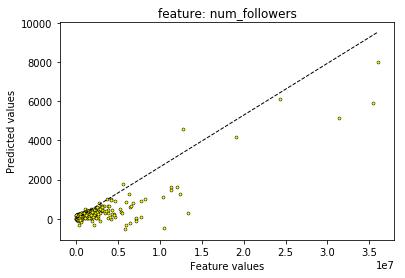

<Figure size 432x288 with 0 Axes>

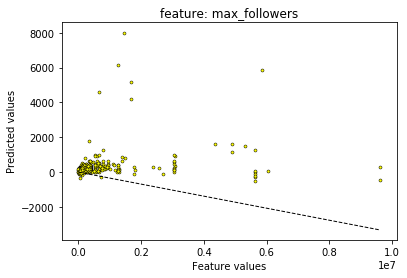

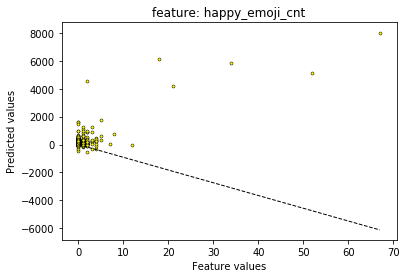

In [140]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_patriots)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 648968.27
R square value: 0.8941854974883665
P values:  [0.00126445 0.39148527 0.14373893 0.98952572 0.0816078  0.43657724
 0.76774668 0.9238926  0.00171346]
Top three features
feature: hr_of_day , P value: 0.0012644528016667888
Coefficeint:  34.508512357774386
feature: num_tweets , P value: 0.0017134573243640747
Coefficeint:  1.209215444997347
feature: happy_emoji_cnt , P value: 0.0816078030336637
Coefficeint:  -64.2357403888228
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     125.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           7.13e-61
Time:                        16:24:41   Log-Likelihood:                -1159.8
No. Observations:                 143   AIC:                  

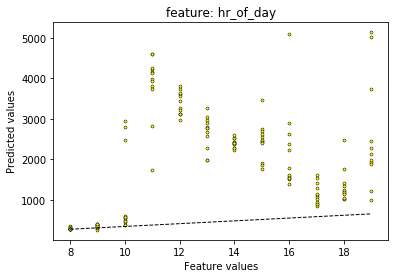

<Figure size 432x288 with 0 Axes>

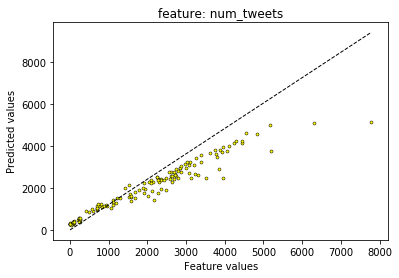

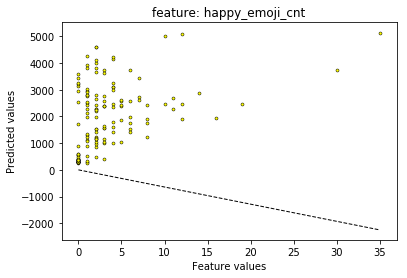

In [141]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 8110.07
R square value: 0.9309226730412096
P values:  [6.21963751e-02 1.66755628e-01 1.88759918e-01 3.83478613e-22
 3.67107856e-05 4.55273158e-02 9.78315483e-01 6.37670773e-08
 5.98209787e-15]
Top three features
feature: num_retweets , P value: 3.8347861336393986e-22
Coefficeint:  -0.09732192700609954
feature: num_tweets , P value: 5.982097867505232e-15
Coefficeint:  2.339149840535315
feature: url_cnt , P value: 6.376707733998975e-08
Coefficeint:  -2.0844892939650275
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     187.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           4.22e-68
Time:                        16:24:42   Log-Likelihood:                -793.20
No. Observations:       

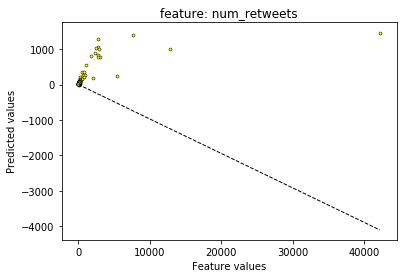

<Figure size 432x288 with 0 Axes>

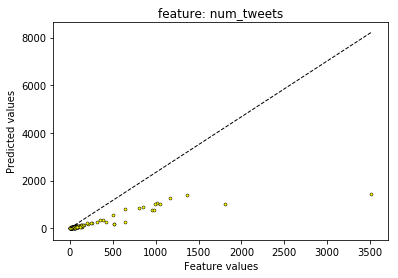

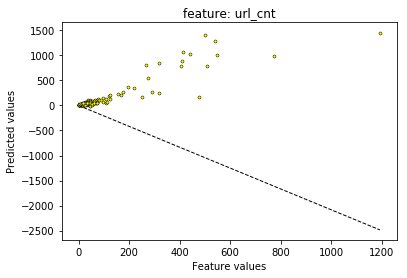

In [142]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

### sb49

41644 646346 55659
Mean squared error: 5993.60
R square value: 0.9022564613799776
P values:  [2.05422767e-01 8.67581307e-01 5.88328294e-01 4.41844409e-03
 8.97166252e-01 2.94306263e-01 7.55301143e-01 2.36432874e-05
 3.71478672e-52]
Top three features
feature: num_tweets , P value: 3.714786718592601e-52
Coefficeint:  1.5870778883598362
feature: url_cnt , P value: 2.3643287394309838e-05
Coefficeint:  -1.312403377969807
feature: num_retweets , P value: 0.004418444089734729
Coefficeint:  0.01363134027859568
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     436.9
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          6.80e-209
Time:                        16:24:49   Log-Likelihood:                -2509.2
No. Obs

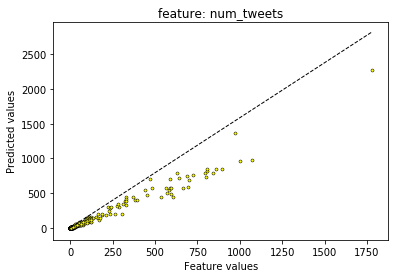

<Figure size 432x288 with 0 Axes>

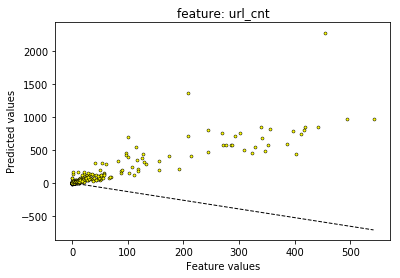

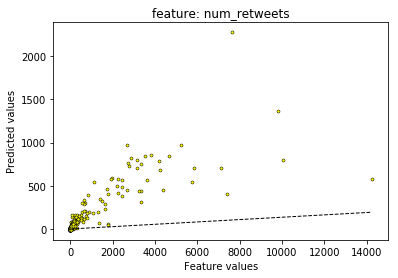

In [143]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_sb49)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 1229086.76
R square value: 0.9590600500051498
P values:  [0.02852265 0.60023582 0.1592681  0.4950804  0.70652296 0.16941452
 0.06269751 0.16391088 0.00087893]
Top three features
feature: num_tweets , P value: 0.0008789326465457666
Coefficeint:  0.5675315086190297
feature: hr_of_day , P value: 0.028522653453330105
Coefficeint:  33.650069183318266
feature: user_mentioned_cnt , P value: 0.06269750628251744
Coefficeint:  0.6560135777833442
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     348.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           2.12e-88
Time:                        16:24:58   Log-Likelihood:                -1205.5
No. Observations:                 143   AIC:            

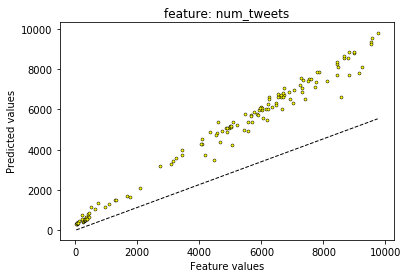

<Figure size 432x288 with 0 Axes>

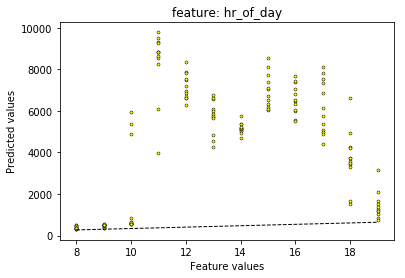

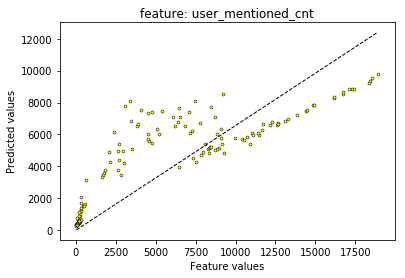

In [144]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 51149.31
R square value: 0.897978805132073
P values:  [6.24671089e-01 8.48166999e-01 6.14351182e-01 6.12677206e-01
 8.22289381e-07 6.10000426e-01 9.68285585e-01 3.14763769e-06
 2.25533463e-01]
Top three features
feature: happy_emoji_cnt , P value: 8.222893806093857e-07
Coefficeint:  70.26317006510844
feature: url_cnt , P value: 3.147637691672448e-06
Coefficeint:  1.7169412582281134
feature: num_tweets , P value: 0.22553346285836226
Coefficeint:  -0.28534733877533175
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     122.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.43e-57
Time:                        16:25:01   Log-Likelihood:                -916.59
No. Observations:        

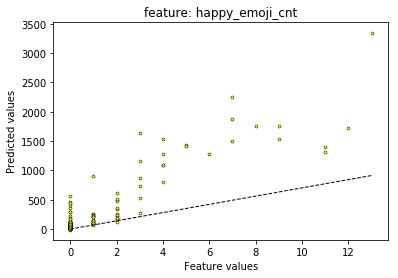

<Figure size 432x288 with 0 Axes>

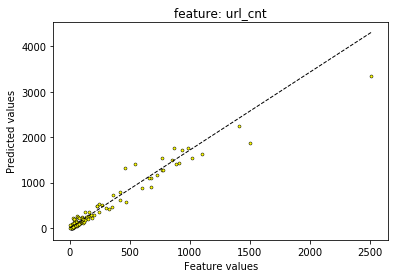

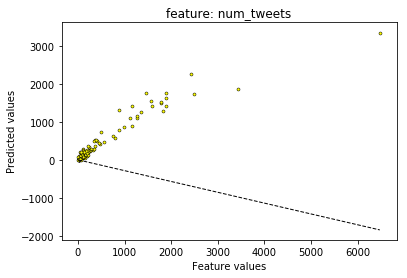

In [145]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

### superbowl

193119 923957 96737
Mean squared error: 482073.44
R square value: 0.5436752319218078
P values:  [4.29762293e-01 9.95237593e-01 9.92018335e-01 5.63805663e-01
 2.98159433e-03 8.15399438e-01 2.24010416e-05 5.90176684e-01
 1.26598707e-01]
Top three features
feature: user_mentioned_cnt , P value: 2.240104155541769e-05
Coefficeint:  1.6256062260073532
feature: happy_emoji_cnt , P value: 0.002981594332098726
Coefficeint:  -16.67306725486926
feature: num_tweets , P value: 0.12659870718854765
Coefficeint:  0.1920656899315867
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     56.92
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           8.65e-68
Time:                        16:25:13   Log-Likelihood:                -3

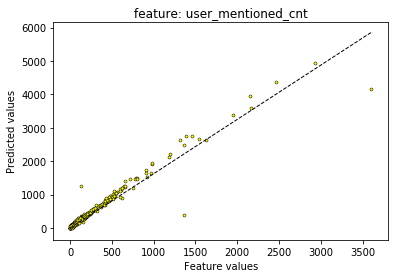

<Figure size 432x288 with 0 Axes>

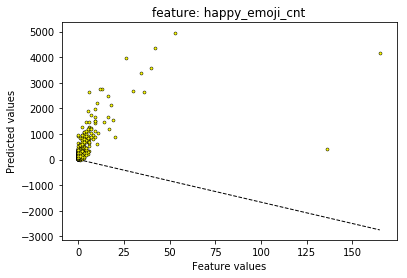

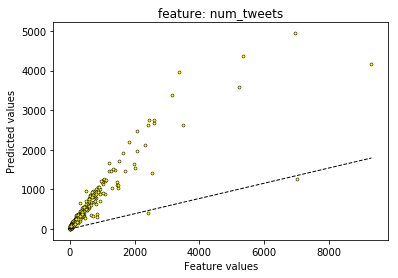

In [146]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_superbowl)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 5396443.79
R square value: 0.9481702055381944
P values:  [9.94280756e-01 2.69132233e-01 6.84552648e-01 6.26434516e-03
 1.68343200e-02 2.08444025e-06 1.78040054e-01 5.43458274e-02
 2.36670554e-20]
Top three features
feature: num_tweets , P value: 2.3667055414990886e-20
Coefficeint:  1.4493068807164038
feature: sad_emoji_cnt , P value: 2.0844402532539224e-06
Coefficeint:  -652.4223423189795
feature: num_retweets , P value: 0.006264345161533318
Coefficeint:  -0.03789636974209866
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     272.4
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.49e-81
Time:                        16:25:25   Log-Likelihood:                -1311.2
No. Observation

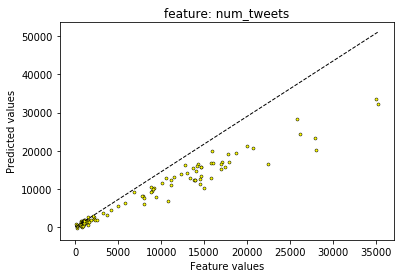

<Figure size 432x288 with 0 Axes>

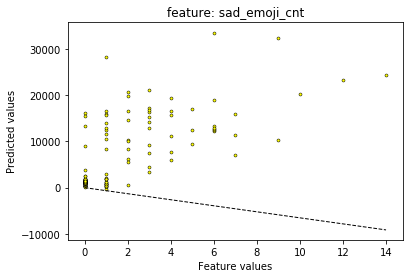

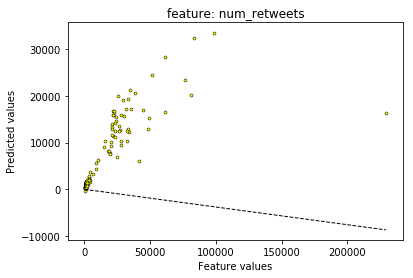

In [147]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 109651.39
R square value: 0.9074163667096606
P values:  [7.61506958e-02 8.52979006e-03 9.62435976e-01 6.86485400e-03
 9.36262681e-01 6.57265747e-01 1.67593806e-01 4.10071035e-02
 4.56764193e-04]
Top three features
feature: num_tweets , P value: 0.0004567641934258261
Coefficeint:  0.8817720203134084
feature: num_retweets , P value: 0.0068648540009085025
Coefficeint:  -0.04342242154100061
feature: max_followers , P value: 0.00852979005595125
Coefficeint:  3.9119997280882525e-05
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     136.1
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           3.44e-60
Time:                        16:25:27   Log-Likelihood:                -967.68
No. Observation

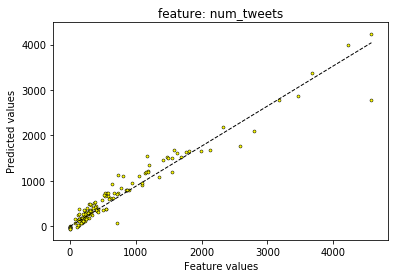

<Figure size 432x288 with 0 Axes>

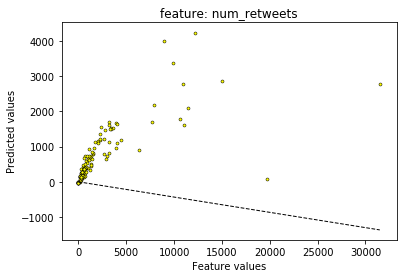

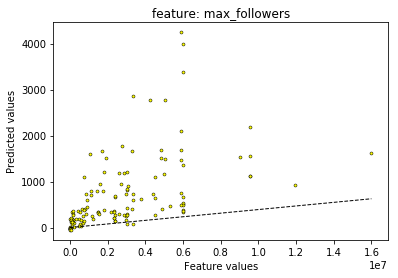

In [148]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

## Question 7

### aggregated data

603733 1970528 249477
Mean squared error: 4137922.90
R square value: 0.5592890845076031
P values:  [5.82148345e-01 7.15969946e-01 8.89697744e-01 7.48736602e-01
 1.22453871e-05 6.33678975e-04 1.02978034e-03 2.22445878e-01
 1.00194432e-01]
Top three features
feature: happy_emoji_cnt , P value: 1.2245387106910851e-05
Coefficeint:  -71.02384619918809
feature: sad_emoji_cnt , P value: 0.000633678974600404
Coefficeint:  687.3872554198737
feature: user_mentioned_cnt , P value: 0.0010297803385369878
Coefficeint:  2.26278300118227
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     60.63
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           5.36e-71
Time:                        16:25:53   Log-Likelihood:            

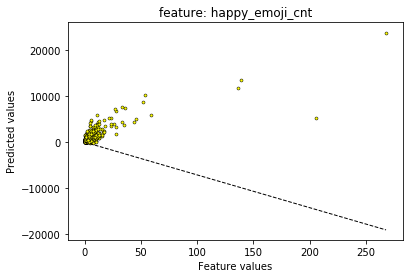

<Figure size 432x288 with 0 Axes>

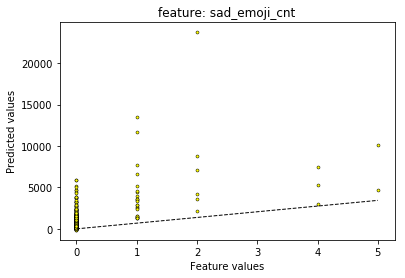

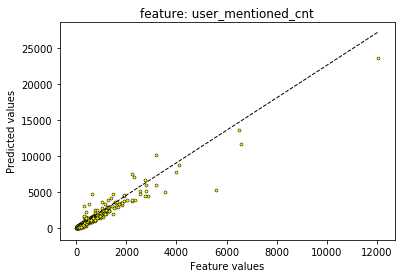

In [149]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_aggregate)
parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 15363770.98
R square value: 0.9493834838422325
P values:  [3.76569206e-02 3.77788531e-01 8.57988993e-01 2.83243341e-02
 9.79732645e-02 1.22364600e-04 9.60068580e-01 5.19626783e-01
 2.98755663e-15]
Top three features
feature: num_tweets , P value: 2.9875566272675797e-15
Coefficeint:  1.3235196850737898
feature: sad_emoji_cnt , P value: 0.00012236459972569236
Coefficeint:  -746.4158694453021
feature: num_retweets , P value: 0.028324334138776726
Coefficeint:  -0.04723363796906333
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     279.3
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           3.06e-82
Time:                        16:26:15   Log-Likelihood:                -1386.1
No. Observatio

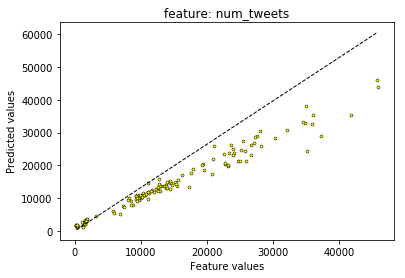

<Figure size 432x288 with 0 Axes>

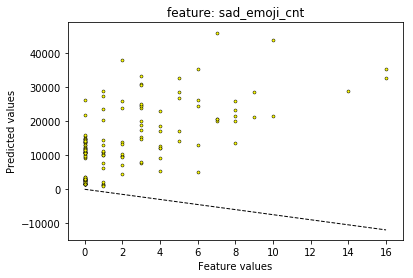

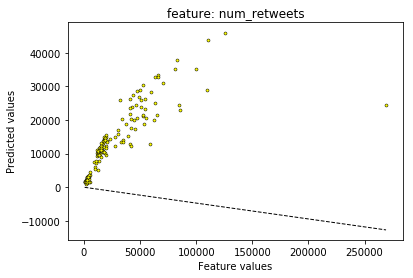

In [150]:
parsed_features = featureExtractionCustomizedFiveMinutes(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

Mean squared error: 389601.33
R square value: 0.9376224861600041
P values:  [8.38734472e-01 7.16366099e-03 2.77574621e-01 1.99080608e-03
 2.79275931e-05 8.07037280e-04 4.75695193e-02 7.92594424e-02
 8.28854541e-01]
Top three features
feature: happy_emoji_cnt , P value: 2.7927593134639798e-05
Coefficeint:  65.99213283803523
feature: sad_emoji_cnt , P value: 0.0008070372801387374
Coefficeint:  -398.42204930074917
feature: num_retweets , P value: 0.001990806076962148
Coefficeint:  -0.04451438736759471
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     208.8
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           7.35e-71
Time:                        16:26:19   Log-Likelihood:                -1052.6
No. Observat

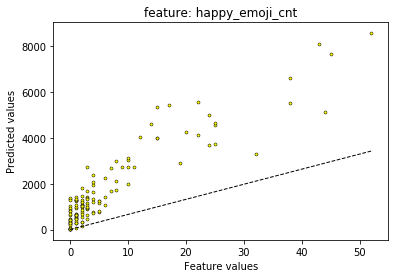

<Figure size 432x288 with 0 Axes>

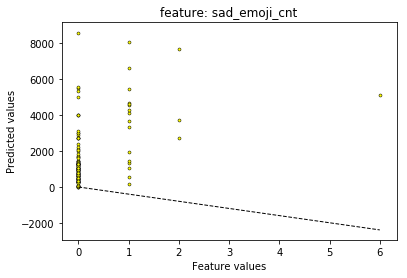

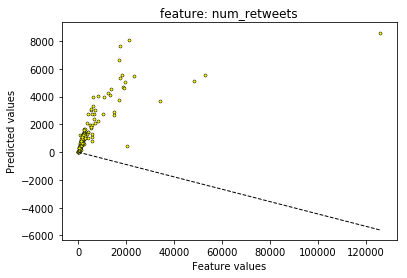

In [151]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair,feature_list_updated)

## Problem 8 Ensemble Method

In [69]:
# parameters = {'max_depth': [10, 20, 40, 60, 80, 100, 200, None], 
#  'max_features': ['auto', 'sqrt'], 
#  'min_samples_leaf': [1, 2, 4], 
#  'min_samples_split': [2, 5, 10], 
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
# clf = RandomForestRegressor()
# grid_search = GridSearchCV(clf, param_grid=parameters, cv=KFold(5, shuffle=True, random_state=42), scoring='neg_mean_squared_error')
# # OLS Top three features and P values
# x_train = np.squeeze(sm.add_constant(train_labels_pair["features"]))
# y_train = np.squeeze(train_labels_pair["labels"])

In [70]:
# grid_search.fit(x_train, y_train)

## Question 11 Neural Network

In [186]:
def GridSearchNeuralNetwork(train_X, train_Y):
    parameters = {'hidden_layer_sizes': [(5),(6),(7),(8),(5,5),(5,6),(5,7),(6,5),(6,6),(6,7),(7,5),(7,6),(7,7),(7,8),(8,7),(8,8),(5,5,6),(5,5,8),(7,7,8),(8,7,7)]}
    mlp = MLPRegressor(random_state=42, max_iter = 20000)
    grid_search = GridSearchCV(mlp, param_grid=parameters, cv=KFold(5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', n_jobs=4)
    grid_search.fit(train_X, train_Y)
    print ("Best layer architecture: ")
    print (grid_search.best_params_)
    print ("Best neg MSE: ")
    print (grid_search.best_score_)
    print ("All scores: ") 
    print (grid_search.cv_results_['mean_test_score'])

In [187]:
#Neural Network
from sklearn.neural_network import MLPRegressor

parsed_features = featureExtractionCustomized(json_aggregate)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
train_X = train_labels_pair["features"]
train_Y = train_labels_pair["labels"]
train_Y = np.ravel(train_Y)
GridSearchNeuralNetwork(train_X, train_Y)

KeyboardInterrupt: 

## Question 12 Standardization

In [184]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

parsed_features = featureExtractionCustomized(json_aggregate)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
train_X = train_labels_pair["features"]
train_Y = train_labels_pair["labels"]
train_X = scaler.fit_transform(train_X)
# train_Y = scaler.fit_transform(train_Y)
train_Y = np.ravel(train_Y)
GridSearchNeuralNetwork(train_X, train_Y)



/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best layer architecture: 
{'hidden_layer_sizes': 6}
Best neg MSE: 
-224304871.73013648
All scores: 
[-2.25904726e+08 -2.24304872e+08 -2.27712191e+08 -2.28349753e+08
 -2.40988861e+08 -2.72493044e+08 -2.46782607e+08 -2.51249954e+08
 -2.40587853e+08 -2.54860009e+08 -2.73342611e+08 -2.45665683e+08
 -2.48995953e+08 -2.49379663e+08 -2.66176527e+08 -2.42238444e+08
 -2.46122016e+08 -2.46731547e+08 -2.49324259e+08 -2.49484207e+08
 -2.43746172e+08 -2.60666923e+08 -2.69359048e+08 -2.84159629e+08
 -2.75688734e+08 -2.49754634e+08 -2.54049719e+08 -2.45372396e+08
 -2.49219730e+08 -2.42334838e+08 -2.51347399e+08 -2.37546819e+08
 -2.55053425e+08 -2.72861680e+08 -2.35914606e+08 -2.39726947e+08
 -2.58003449e+08 -2.95118903e+08 -2.57030182e+08 -2.34415938e+08]


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Question 13 Neural Network for each period

In [185]:
first_period_json, second_period_json, third_period_json = splitTweetByTimePeriod(json_aggregate)

parsed_features = featureExtractionCustomized(first_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
train_X = train_labels_pair["features"]
train_Y = train_labels_pair["labels"]
train_X = scaler.fit_transform(train_X)
# train_Y = scaler.fit_transform(train_Y)
train_Y = np.ravel(train_Y)

GridSearchNeuralNetwork(train_X, train_Y)

603733 1970528 249477


KeyboardInterrupt: 

In [158]:
parsed_features = featureExtractionCustomized(second_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
train_X = train_labels_pair["features"]
train_Y = train_labels_pair["labels"]
train_X = scaler.fit_transform(train_X)
# train_Y = scaler.fit_transform(train_Y)
train_Y = np.ravel(train_Y)

GridSearchNeuralNetwork(train_X, train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best layer architecture: 
{'hidden_layer_sizes': (5, 5, 6)}
Best neg MSE: 
-0.2965632765620483
All scores: 
[-1.22324472 -0.97013956 -2.75263822 -0.76336279 -0.5700046  -1.10840096
 -0.98688306 -0.95838455 -1.59311437 -1.47232344 -0.6150229  -1.27264904
 -0.73870565 -0.74067006 -0.43377471 -0.7086082  -0.29656328 -0.59744802
 -0.90893876 -1.2682692  -0.44938042 -0.89786972 -0.82691817 -1.22868505
 -0.88435085 -0.54437867 -0.83024568 -0.95684084 -0.9076344  -0.89757322
 -0.42427199 -0.59270324 -0.74670801 -0.48118657 -0.59221359 -0.45520277
 -0.42932707 -0.4133317  -0.84017675 -0.50069736]


In [159]:
parsed_features = featureExtractionCustomized(third_period_json)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
train_X = train_labels_pair["features"]
train_Y = train_labels_pair["labels"]
train_X = scaler.fit_transform(train_X)
# train_Y = scaler.fit_transform(train_Y)
train_Y = np.ravel(train_Y)

GridSearchNeuralNetwork(train_X, train_Y)

Best layer architecture: 
{'hidden_layer_sizes': (5, 5, 8)}
Best neg MSE: 
-0.14738597678491064
All scores: 
[-0.63823076 -0.78548215 -0.36177169 -0.36846532 -0.30364992 -0.38356979
 -0.40588927 -0.31664161 -0.58167235 -0.20604314 -0.18855789 -0.34669715
 -0.26767321 -0.36090127 -0.17067514 -0.2575798  -0.45122306 -0.14738598
 -0.17624322 -0.40460281 -0.24569976 -0.3900619  -0.33150617 -0.27671454
 -0.34085703 -0.32435448 -0.24064894 -0.27865925 -0.38994688 -0.3643363
 -0.4741721  -0.19742615 -0.29712084 -0.28174622 -0.24234097 -0.19802231
 -0.19810496 -0.22507701 -0.30570921 -0.28596858]


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Question 14 Using 6x window to predict

In [164]:
#Load test file
test_file_direct = "ECE219_tweet_test_updated/"

def loadTestFile(file_direct, sample_num, period_num):
    json_objects = list()
    filename = "updated_sample" + str(sample_num) + "_period" + str(period_num) +".txt"
    with open(file_direct + filename, "r") as file:
        line = file.readline()
        while line:
            json_objects.append(json.loads(line))
            line = file.readline()
    print(len(json_objects))
    return json_objects

json_sample0_period1 = loadTestFile(test_file_direct, 0,1)
json_sample0_period2 = loadTestFile(test_file_direct, 0,2)
json_sample0_period3 = loadTestFile(test_file_direct, 0,3)
json_sample1_period1 = loadTestFile(test_file_direct, 1,1)
json_sample1_period2 = loadTestFile(test_file_direct, 1,2)
json_sample1_period3 = loadTestFile(test_file_direct, 1,3)
json_sample2_period1 = loadTestFile(test_file_direct, 2,1)
json_sample2_period2 = loadTestFile(test_file_direct, 2,2)
json_sample2_period3 = loadTestFile(test_file_direct, 2,3)

568
13377
410
2280
5549
305
953
152
399


In [183]:
test_file_list = [json_sample0_period1, json_sample0_period2,
                 json_sample0_period3, json_sample1_period1,
                 json_sample1_period2, json_sample1_period3,
                 json_sample2_period1, json_sample2_period2,
                 json_sample2_period3]


def get6xWindow(time):
    if time < datatime_start or time > datatime_end:
        parsed_time = time - datetime.timedelta(minutes=time.minute, 
                                                  seconds = time.second,
                                                  microseconds = time.microsecond)
        window_end_time = parsed_time + datetime.timedelta(hours = 6)
    else:
        parsed_time = time - datetime.timedelta(minutes=time.minute%5, 
                                                  seconds = time.second,
                                                  microseconds = time.microsecond)
        window_end_time = parsed_time + datetime.timedelta(minutes=30)
    return parsed_time, window_end_time
            
def featureExtractionCustomizedSixWindow(json_objects):
    hr2feature = dict()
    happy_emoji = [":)", ":-)", ":')", ":]", "=]", ":)"]
    sad_emoji = [":-(", ":'(", ":[", "=["]
    
    for i in range(len(json_objects)):
        time = datetime.datetime.fromtimestamp(json_objects[i]['citation_date'], pytz.timezone('America/Los_Angeles'))
        parsed_time, window_end_time = get6xWindow(time)
        tweet_text = json_objects[i]['text']
        hour_time = parsed_time + timedelta(hours=1)
        while hour_time <= window_end_time:
            if hour_time in hr2feature:
                hr2feature[hour_time]["num_tweets"] += 1
                hr2feature[hour_time]["num_retweets"] += json_objects[i]['total_citations']
                hr2feature[hour_time]["num_followers"] += json_objects[i]['followers']
                hr2feature[hour_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
                hr2feature[hour_time]["user_mentioned_cnt"] += json_objects[i]['user_mentioned_cnt']
                hr2feature[hour_time]["url_cnt"] += json_objects[i]['url_cnt']
            else:
                hr2feature[hour_time] = dict()
                hr2feature[hour_time]["hr_of_day"] = parsed_time.hour
                hr2feature[hour_time]["num_tweets"] = 1
                hr2feature[hour_time]["num_retweets"] = json_objects[i]['total_citations']
                hr2feature[hour_time]["num_followers"] = json_objects[i]['followers']
                hr2feature[hour_time]["max_followers"] = json_objects[i]['followers']
                hr2feature[hour_time]["happy_emoji_cnt"] = 0
                hr2feature[hour_time]["sad_emoji_cnt"] = 0
                hr2feature[hour_time]["user_mentioned_cnt"] = json_objects[i]['user_mentioned_cnt']
                hr2feature[hour_time]["url_cnt"] = json_objects[i]['url_cnt']

            if hasEmoticon(happy_emoji, tweet_text):
                hr2feature[hour_time]["happy_emoji_cnt"] += 1
            if hasEmoticon(sad_emoji, tweet_text):
                hr2feature[hour_time]["sad_emoji_cnt"] += 1
            hour_time += timedelta(hours=1)
            
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
            hr2feature[hour_time]["sad_emoji_cnt"] = 0
            hr2feature[hour_time]["happy_emoji_cnt"] = 0
            hr2feature[hour_time]["user_mentioned_cnt"] = 0
            hr2feature[hour_time]["url_cnt"] = 0
            
        hour_time += timedelta(hours=1)
    return hr2feature
    
    
    

In [ ]:
parsed_features = featureExtractionCustomizedSixWindow(json_sample0_period1)
print (parsed_features.keys())
parsed_features = featureExtractionCustomizedFiveMinutesSixWindow(json_sample0_period)
print (parsed_features.keys())